In [355]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F

In [48]:
df = pd.read_csv("train.csv")

In [28]:
print(df.shape)
p = int(np.sqrt(df.shape[1]-1))
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


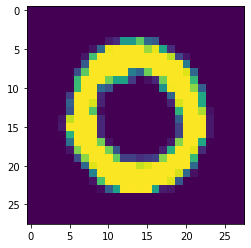

In [38]:
plt.imshow(df.iloc[1,1:].as_matrix().reshape(p,-1))

In [175]:
chosen = np.random.choice(range(len(df)),int(.9*len(df)),replace = False)
train_df = df.iloc[chosen,:]
valid_df = df.drop(axis = 0, index = chosen)
print(len(valid_df))
print(len(df))

4200
42000


In [265]:
class MnistDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, transform=None, width = p):
        self.data_frame = df
        self.transform = transform
        self.width = width

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        pixels = self.data_frame.iloc[idx,1:].values.reshape(1,self.width,-1)
        label = self.data_frame.iloc[idx,0]
        if self.transform:
            pixels = self.transform(pixels)
        return [label,pixels]

In [314]:
train_dataset = MnistDataset(df = train_df)
valid_set = MnistDataset(df = valid_df)
all_set = MnistDataset(df = df)

In [316]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=False, num_workers=6)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=1,
                                          shuffle=False, num_workers=6)
allloader = torch.utils.data.DataLoader(all_set, batch_size=100,
                                          shuffle=False, num_workers=6)

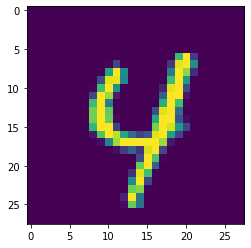

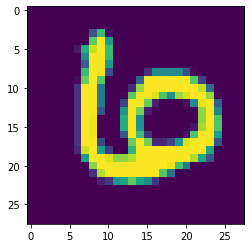

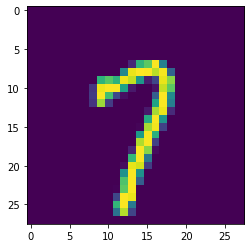

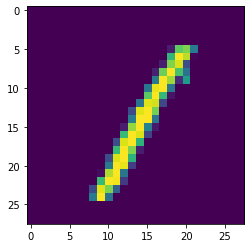

In [383]:
for i,data in enumerate(trainloader,0):
    if i >= 1:
        break
    label, pixels = data
    for j in range(4):
        plt.imshow(pixels.numpy()[j][0])
        plt.show()

In [388]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 24)
        self.fc2 = nn.Linear(24, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [389]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=.003, momentum=.9)

In [390]:
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        labels, inputs = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.to(dtype = torch.float))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            valid_cor = 0.0
            total = 0
            for data in validloader:
                labels, inputs = data
                total += len(labels)
                valid_outputs = net(inputs.to(dtype = torch.float))
                valid_predict = torch.max(valid_outputs.data,1)[1]
                valid_cor += (valid_predict == labels).item()
            print('valid accuracy: %.4f'%(100*float(valid_cor)/total))

print('Finished Training')

[1,   100] loss: 2.626
valid accuracy: 58.5000
[1,   200] loss: 0.648
valid accuracy: 91.5476
[1,   300] loss: 0.310
valid accuracy: 91.9286
[2,   100] loss: 0.203
valid accuracy: 95.5952
[2,   200] loss: 0.168
valid accuracy: 95.8333
[2,   300] loss: 0.159
valid accuracy: 95.2857
[3,   100] loss: 0.129
valid accuracy: 96.5238
[3,   200] loss: 0.120
valid accuracy: 96.1190
[3,   300] loss: 0.127
valid accuracy: 96.6429
[4,   100] loss: 0.105
valid accuracy: 97.1190
[4,   200] loss: 0.095
valid accuracy: 97.1667
[4,   300] loss: 0.095
valid accuracy: 97.2381
[5,   100] loss: 0.083
valid accuracy: 97.2143
[5,   200] loss: 0.077
valid accuracy: 97.1667
[5,   300] loss: 0.074
valid accuracy: 97.2381
[6,   100] loss: 0.072
valid accuracy: 97.2857
[6,   200] loss: 0.070
valid accuracy: 97.6190
[6,   300] loss: 0.064
valid accuracy: 97.5000
[7,   100] loss: 0.068
valid accuracy: 97.4762
[7,   200] loss: 0.053
valid accuracy: 97.2619
[7,   300] loss: 0.060
valid accuracy: 97.7143
[8,   100] lo

In [351]:
net_all = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_all.parameters(), lr=.003, momentum=.9)

In [352]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(allloader, 0):
        # get the inputs
        labels, inputs = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net_all(inputs.to(dtype = torch.float))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.096
[1,   200] loss: 0.214
[1,   300] loss: 0.162
[1,   400] loss: 0.113
[2,   100] loss: 0.118
[2,   200] loss: 0.101
[2,   300] loss: 0.096
[2,   400] loss: 0.076
[3,   100] loss: 0.079
[3,   200] loss: 0.074
[3,   300] loss: 0.077
[3,   400] loss: 0.058
[4,   100] loss: 0.071
[4,   200] loss: 0.060
[4,   300] loss: 0.063
[4,   400] loss: 0.058
[5,   100] loss: 0.059
[5,   200] loss: 0.056
[5,   300] loss: 0.054
[5,   400] loss: 0.046
[6,   100] loss: 0.057
[6,   200] loss: 0.048
[6,   300] loss: 0.050
[6,   400] loss: 0.042
[7,   100] loss: 0.043
[7,   200] loss: 0.043
[7,   300] loss: 0.047
[7,   400] loss: 0.040
[8,   100] loss: 0.050
[8,   200] loss: 0.041
[8,   300] loss: 0.042
[8,   400] loss: 0.034
[9,   100] loss: 0.040
[9,   200] loss: 0.036
[9,   300] loss: 0.044
[9,   400] loss: 0.031
[10,   100] loss: 0.038
[10,   200] loss: 0.034
[10,   300] loss: 0.036
[10,   400] loss: 0.030
Finished Training


In [368]:
test_df = pd.read_csv("test.csv")
test_np = test_df.values.reshape([-1,1,28,28]).astype(float)
test_data = torch.from_numpy(test_np)

In [365]:
pred_test = torch.argmax(net_all(test_data.to(dtype = torch.float)),1)

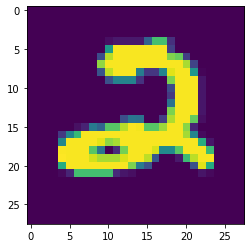

tensor(2)


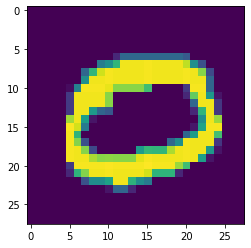

tensor(0)


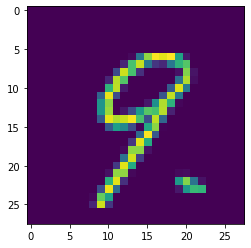

tensor(9)


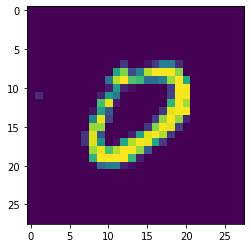

tensor(9)


In [377]:
for i in range(4):
    plt.imshow(test_np[i][0])
    plt.show()
    print(pred_test[i])

In [380]:
def export_csv(model_name, predictions):
    df = pd.DataFrame(predictions.tolist(), columns=['Label'])
    df['ImageId'] = df.index + 1
    file_name = f'submission_{model_name}.csv'
    print('Saving ',file_name)
    df[['ImageId','Label']].to_csv(file_name, index = False)
export_csv("cnn1",pred_test)
torch.save(net_all.state_dict(), 'model.ckpt')

Saving  submission_cnn1.csv
